In [1]:
import numpy as np
from numpy.random import multivariate_normal
from numpy.random import rand
from numpy.linalg import inv, det

from scipy.special import digamma, gamma, loggamma

from sklearn.preprocessing import normalize

from numpy.random import randint, rand

import seaborn as sb
import matplotlib.pyplot as plt
%matplotlib inline

from time import time

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms

def confidence_ellipse(mu, cov, ax, n_std=3.0, facecolor='none', **kwargs):
    """
    Create a plot of the covariance confidence ellipse given the covariance and the center of the ellipse

    """
    pearson = cov[0, 1]/np.sqrt(cov[0, 0] * cov[1, 1])

    # Using a special case to obtain the eigenvalues of this
    # two-dimensionl dataset.
    ell_radius_x = np.sqrt(1 + pearson)
    ell_radius_y = np.sqrt(1 - pearson)
    ellipse = Ellipse((0, 0), width=ell_radius_x * 2, height=ell_radius_y * 2,
                      facecolor=facecolor, **kwargs)

    # Calculating the stdandard deviation of x from
    # the squareroot of the variance and multiplying
    # with the given number of standard deviations.
    scale_x = np.sqrt(cov[0, 0]) * n_std
#     mean_x = np.mean(x)

    # calculating the stdandard deviation of y ...
    scale_y = np.sqrt(cov[1, 1]) * n_std
#     mean_y = np.mean(y)

    transf = transforms.Affine2D() \
        .rotate_deg(45) \
        .scale(scale_x, scale_y) \
        .translate(mu[0], mu[1])

    ellipse.set_transform(transf + ax.transData)
    return ax.add_patch(ellipse)


In [34]:
def random_gaussian(D=2, size=100):
    mu = rand(D)*4
    sigma = np.diag(rand(D)*2)
    dett = -1
    
    while dett<0:
        sigma = rand(D,D)
        dett = det(sigma)
#     print('sigma:',sigma,'\n')
    X = multivariate_normal(mean=mu, cov=sigma, size=size)
    return X

def dist(u,v):
    return np.linalg.norm(u-v)

def k_means(X, k, max_iters=100, tol=1e-7):
    N, D = X.shape
    max_axis = np.array([ max(X[:, D_i]) for D_i in range(D)])
    min_axis = np.array([ min(X[:, D_i]) for D_i in range(D)])
    range_axis = max_axis - min_axis
    k_centers_old = min_axis + rand(k,D)*range_axis
    labels = np.zeros(N)
    
    for iter in range(max_iters):
        #compute distance and assign label
        for idx,x in enumerate(X):
            distances = np.array([dist(x, center) for center in k_centers_old])
            labels[idx] = np.argmin(distances)
        #recompute centers
        k_centers = np.array([ np.mean(X[labels==label], axis=0) for label in range(k)])
        if dist(k_centers, k_centers_old)< tol:
            print('k-means convergence reached')
            return labels
        k_centers_old = k_centers
        
    return labels


def log_B_wishart(W, nu, D):
    B = -nu/2*np.log(np.abs(det(W))) - nu*D/2*np.log(2) - D*(D-1)/4*np.log(np.pi) - np.sum([loggamma((nu+1-i)/2)  for i in range(1,D+1)])
    return B


def plot_labels(X, labels, k, ax, title=None):
    for label in range(k):
        ax.scatter(X[labels==label, 0], X[labels==label, 1], label=label)
        ax.set_title(title)
        ax.legend()
    return

def plot_probs(X, r, mu, ax, k):
    ax.scatter(X[:,0], X[:,1], color=r, label='X')
    ax.scatter(mu[:,0], mu[:,1], s=100, color='black', label='center of gaussians')
    for ind in range(k):
        confidence_ellipse(mu=self.m[ind], cov=self.W[ind], ax=ax, edgecolor='black', n_std=3)
    return 
    

class VariationalGaussianMixtureModel():
    
    def __init__(self,  k_real, D=2, size=1000):
        self.k_real = k_real
        self.create_data( k_real, D, size)
        self.labels = []
        self.time = 0

    def create_data(self, k_real, D=2, size=100, n_std=1):
        """ Create a dataset with k_real gaussian distributions D-variate with size points"""
        self.D = D
        X = np.array([]).reshape(0, self.D)
        labels = np.array([])
        for label in range(k_real):
            x = random_gaussian(self.D, size)
            labels = np.concatenate((labels, [label]*size))
            X = np.concatenate((X,x))
        self.X = X
        self.labels_real = labels
        return 
    
    def fit(self, k, mode='k-means', n_std=1, ax=None):
        self.time = time()
        self.k = k
#         self.labels = k_means(self.X, self.k)
#         self.X = X.copy()
        self.n, self.D = self.X.shape
        self.init_mode = mode
        
        #initial values for parameters
        self.alpha_0 =  10
        self.nu_0 = self.D + 1
        self.Sigma_0 = np.cov(self.X.T)
        self.beta_0 = 2
        Lambda_0 = inv(self.Sigma_0)/ self.beta_0
        self.W_0 = Lambda_0 / self.nu_0
        if self.init_mode=='k-means':
            self.labels = k_means(self.X, self.k)
            self.m_0 = np.array([ np.mean(self.X[self.labels==label], axis=0) for label in range(self.k)])
            
        elif self.init_mode=='default':
            self.labels = np.array([0]*self.n)
            self.m_0 = multivariate_normal(mean=np.mean(self.X, axis=0), cov=np.cov(self.X.T), size=self.k)
        else:
            print('ERROR: Invalid mode detected')
        
        #initializing parameters
        self.alpha = np.array([self.alpha_0]*self.k)
        self.m = self.m_0
        self.beta = np.array([self.beta_0]*self.k)
        self.W = np.array([self.W_0]*self.k)
        self.nu = np.array([self.nu_0]*self.k)
        self.Sigma = np.array([self.Sigma_0]*self.k)
    
        self.time = time() - self.time
        
        if type(ax) != type(None):
            ax.set_title(self.init_mode+' init and gaussians init')
            self.plot_init(ax=ax, n_std=n_std)
        return 
    
    def EM(self, max_iters=100, mile=20, n_std=3, tol=1e-5, n_batches=1, ax_list=None, probs=True):
        """ Expectation Maximization Algorithm for Variational Inference"""
            
        timer = time()
        
        if type(mile)==int:
            condition = lambda x: x%mile==0
        if type(mile)==np.ndarray or type(mile)==list:
            condition = lambda x: x in mile
        
        elbo_old = -np.inf
        elbo = 0
        self.elbo = []
        full_index = np.arange(self.n)
        if n_batches ==0:
            n_batches = self.n
        batch_size = int(np.ceil(float(self.n)/n_batches))
        proceed = True
        iters=0
        ax_ind = 0
        
        while iters<max_iters and proceed:
            
            np.random.shuffle(full_index)
            for i in range(n_batches):
                index = full_index[i*batch_size : (i+1)*batch_size]

                #E-step
                self.get_r()
                self.get_statistics(self.X[index], self.r[index])

                #M-step
                self.update_parameters()

                #get ELBO
                elbo = self.get_ELBO()
                self.elbo.append( elbo)
                if np.abs(elbo - elbo_old) < tol:
                    print('ELBO convergence reached')
                    proceed = False
                    if type(ax_list) == np.ndarray or type(ax_list)== list:
                        ax = ax_list[-1]
                        ax.set_title('Iterations:'+str(iters))
                        self.plot_probs(ax=ax, n_std=n_std, probs=probs)
                        ax.legend()
                        self.time = self.time + time() - timer
                    return
                elif iters >= max_iters:
                    print('ELBO didn\'t converge, max_iters reached')
                    proceed = False
                    self.time = self.time + time() - timer
                    return
                elbo_old = elbo

                if condition(iters):
                    if type(ax_list) == np.ndarray or type(ax_list)== list:
                        ax = ax_list[ax_ind]
                        ax.set_title('Iterations:'+str(iters))
                        self.plot_probs(ax=ax, n_std=n_std, probs=probs)
                        ax.legend()
                        ax_ind += 1
                iters +=1
                    
        print('ELBO didn\'t converge, max_iters reached')
        if type(ax_list) == np.ndarray or type(ax_list)== list:
            ax = ax_list[-1]
            ax.set_title('Iterations:'+str(iters))
            self.plot_probs(ax=ax, n_std=n_std, probs=probs)
            ax.legend()        
        self.time = self.time + time() - timer
        return 
    
    def get_r(self):
        """  computes r_nk from Bishop eq.(10.67), that are the responsibilities as part of the E-step"""

        #computing pi_tilde eq. (10.66)
        alpha_hat = np.sum(self.alpha)
        pi_tilde = np.array([ np.exp( digamma(alpha_k))  for alpha_k in self.alpha ]) * np.exp(- digamma(alpha_hat))

        #computing Lambda_tilde eq. (10.65)
        Lambda_tilde = np.array([ np.abs(det(W_k))* np.exp( np.sum([digamma(0.5*(nu_k+1-i))  for i in range(1,self.D+1)]) ) for nu_k,W_k in zip(self.nu, self.W)]) * 2**(self.D)

        #computing term independent of n in exponential in eq. (10.67)
        exp_term = np.exp(- self.D*0.5/self.beta) 

        #creating r
        r = np.array([ np.sqrt(Lambda_tilde) *pi_tilde * exp_term]*self.n )

        #matrix Expectations eq.(10.64) or exponential part of eq. (10.67)
        for n_i in range(self.n):
            for k_i in range(self.k):
                x_centered = self.X[n_i]- self.m[k_i]
                r[n_i, k_i] *= np.exp(-0.5*self.nu[k_i]*(  (x_centered).reshape(1,-1) @ self.W[k_i] @ (x_centered).reshape(-1,1) ) )

        #normalization over gaussians/row-stochastic of r_nk using eq. (10.49)
        self.r = normalize(r, norm='l1')
        return 
    
    def get_labels(self):
        """ assigns a gaussian to each point by taking the gaussian with"""
        return np.argmax(self.r, axis=1)

    def get_statistics(self, X, r):
        """ statistics N_k, x_bar_k, S_k from Bishop eqs. (10.51), (10.52), (10.53) respectively"""
        self.N = np.sum(r, axis=0)
        self.x_bar = (r.T @ X)/ self.N[:, None]
        X_centered = np.array([ X-x_k for x_k in self.x_bar])
        self.S = np.array([ (r_k* X_k.T)@ X_k / N_k for r_k, X_k, N_k in zip(r.T, X_centered, self.N) ])
        return 

    def update_parameters(self):
        """ update the parameters of the prior distributions incorporating the statistics calculated according to eqs. (10.58), (10.60), (10.61), (10.62), (10.63) as part of the M-step"""
        self.alpha = self.alpha_0 + self.N
        self.beta = self.beta_0 + self.N
        self.m = (self.beta_0*self.m_0 + self.N[:,None]*self.x_bar)/ self.beta[:,None]
        x_bar_centered = self.x_bar - self.m_0
        self.W =  np.array([  inv( inv(self.W_0)+N_k*S_k+ self.beta_0*N_k/(self.beta_0+N_k)*(x_k.reshape(-1,1) @ x_k.reshape(1,-1)) ) for  N_k, S_k, x_k in zip(self.N, self.S, x_bar_centered)])
        self.nu = self.nu_0 + self.N
        self.Sigma = np.array([ inv( W * nu) for W, beta, nu in zip(self.W, self.beta, self.nu)])
        return
    
    
    def get_ELBO(self):
        """Lower bound of the model or ELBO computation based on eq. (10.70) in Bishop"""
        
        ln_lambda_tilde = np.array([ np.log(np.abs(W_k)) + self.D*np.log(2)+ np.sum([digamma(0.5*(nu_k+1-i))  for i in range(1,self.D+1)]) for nu_k, W_k in zip(self.nu, self.W)])
        ln_pi_tilde = np.array([digamma(alpha_k) for alpha_k in self.alpha]) - digamma(np.sum(self.alpha))
        
        #expectation term 1, eq. (10.71)
        x_bar_centered = self.x_bar - self.m
        exp1 = 0.5* np.sum([ N_k*( ln_lambda_k - self.D/beta_k - nu_k* (S_k@W_k).trace() - nu_k*(x_k.reshape(1,-1)@ W_k @ x_k.reshape(-1,1)) - self.D*np.log(2*np.pi) ) for N_k, ln_lambda_k, beta_k, nu_k, S_k, W_k, x_k in zip(self.N, ln_lambda_tilde, self.beta, self.nu, self.S, self.W, x_bar_centered)])
        
        #expectation term 2, eq. (10.72)
        exp2 = np.sum( self.r * ln_pi_tilde )
        
        #expectation term 3, eq. (10.73)
        exp3 = loggamma(self.alpha_0*self.k) - loggamma(self.alpha_0)*self.k  + (self.alpha_0 - 1)* np.sum(ln_pi_tilde)
        
        #expectation term 4 , eq. (10.74)
        m_centered = self.m - self.m_0
        exp4 = 0.5* np.sum([self.D*np.log(self.beta_0/(2*np.pi)) + ln_lambda_k - self.D*self.beta_0/beta_k -self.beta_0*nu_k* (m_k.reshape(1,-1))@W_k@(m_k.reshape(-1,1))  for beta_k, nu_k, W_k, m_k, ln_lambda_k in zip(self.beta, self.nu, self.W, m_centered, ln_lambda_tilde)]) + self.k*log_B_wishart(self.W_0, self.nu_0, self.D) + (self.nu_0-self.D-1)/2 *np.sum(ln_lambda_tilde) - 0.5*np.sum([nu_k*( inv(self.W_0) @ W_k ).trace() for nu_k, W_k in zip(self.nu, self.W)]) 

    
        #expectation term 5, eq. (10.75)
        exp5 = np.sum( self.r * np.log(self.r) )
        
        #expectation term 6, eq. (10.76)
        exp6 = (self.alpha - 1)@ln_pi_tilde +  loggamma(np.sum(self.alpha)) - np.sum([loggamma(alpha_k) for alpha_k in self.alpha])
        
        #expectation term 7, eq. (10.77)
        exp7 = np.sum([0.5*ln_lambda_k+ self.D/2*np.log(beta_k/(2*np.pi))-self.D/2 + log_B_wishart(W_k, nu_k, self.D) + (nu_k-self.D-1)/2*ln_lambda_k - nu_k*self.D/2    for ln_lambda_k, beta_k, W_k, nu_k in zip(ln_lambda_tilde, self.beta, self.W, self.nu)])
        return exp1 + exp2 + exp3 +  exp4 -  exp5 - exp6 - exp7 
    
    def plot_predicted(self):
        labels_hat = self.get_labels()
        plot_labels(self.X, labels_hat, self.k)
        
    def plot_probs(self, ax, n_std=3, probs=True):
        if probs:
            color = self.r
            facecolor = 'black'
        else:
            color = self.get_labels()
        ax.scatter(self.X[:,0], self.X[:,1], c=color, label='X', s=10)
        ax.scatter(self.m[:,0], self.m[:,1], s=100, color='black', label='center of gaussians')
        for ind in range(self.k):
            alpha = self.alpha[ind]/self.alpha.sum()
            confidence_ellipse(mu=self.m[ind], cov=self.Sigma[ind], ax=ax, edgecolor='black', n_std=n_std, facecolor='black', alpha=alpha)
        return 

    def plot_init(self, ax, n_std=3):
        for label in range(self.k):
            ax.scatter(self.X[self.labels==label, 0], self.X[self.labels==label, 1], label=label)

        for ind in range(self.k):
            confidence_ellipse(mu=self.m[ind], cov=self.Sigma[ind], ax=ax, edgecolor='black', n_std=n_std)
        ax.scatter(self.m[:,0], self.m[:,1], s=100, color='black', label='center of gaussians')
        ax.legend()
        return
    
    def plot_dataset(self, ax, n_std=3):
        ax.set_title('Complete Dataset')
        for label in range(self.k_real):
                ax.scatter(self.X[self.labels_real==label, 0], self.X[self.labels_real==label, 1], label=label)
        ax.legend()
        return 
    
    def plot_ELBO(self, ax):
        ax.plot(self.elbo, label=self.init_mode)
        ax.set_title('Convergence')
        ax.set_xlabel('Iterations')
        ax.set_ylabel('ELBO')
        ax.legend()
        return

C:\Users\alcom\anaconda3\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: covariance is not positive-semidefinite.
  # Remove the CWD from sys.path while we load stuff.


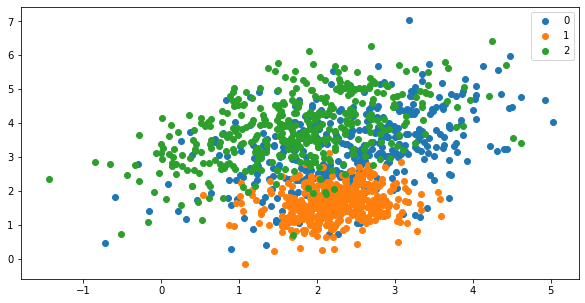

ELBO didn't converge, max_iters reached


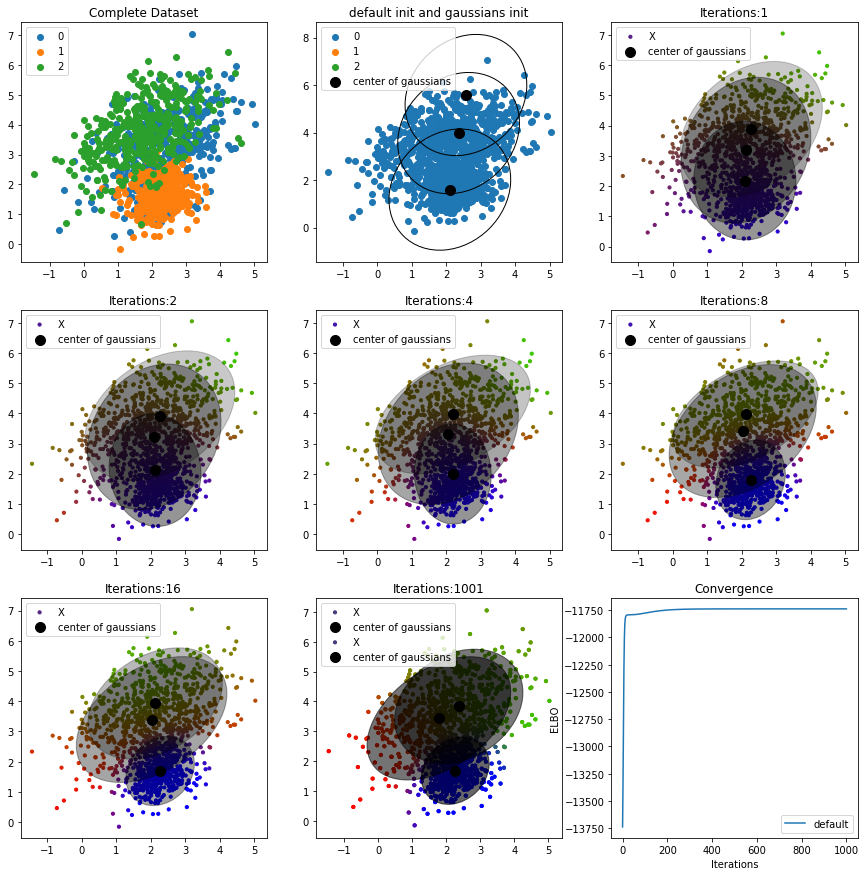

Total time: 40.64388394355774


In [35]:
k_real = 3
vgmm = VariationalGaussianMixtureModel(k_real, size=400)
fig, ax = plt.subplots( figsize=(10,5))
ax.set_title('Original dataset')
plot_labels(vgmm.X, vgmm.labels_real, k = k_real, ax=ax)
plt.show()




k=3
fig, ax = plt.subplots(3,3, figsize=(15,15))
axes = ax.flatten()
vgmm.plot_dataset(n_std=2, ax = axes[0])
vgmm.fit(k=k, n_std=2, mode='default', ax=axes[1])
vgmm.EM(max_iters=1001, mile=[1,2,4,8,16,1000], n_std=2,  tol=1e-10, n_batches=1, ax_list=axes[2:-1], probs=True)
vgmm.plot_ELBO(axes[-1])
plt.show()
print('Total time:',vgmm.time)

C:\Users\alcom\anaconda3\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: covariance is not positive-semidefinite.
  # Remove the CWD from sys.path while we load stuff.


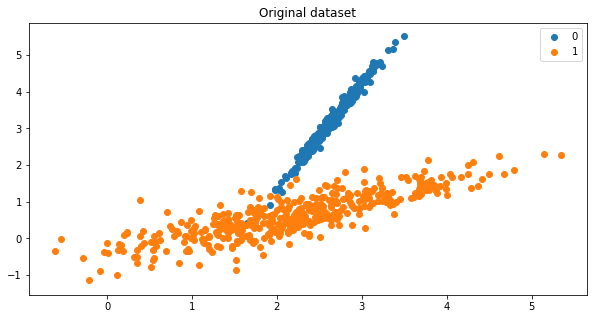

No handles with labels found to put in legend.


ELBO convergence reached


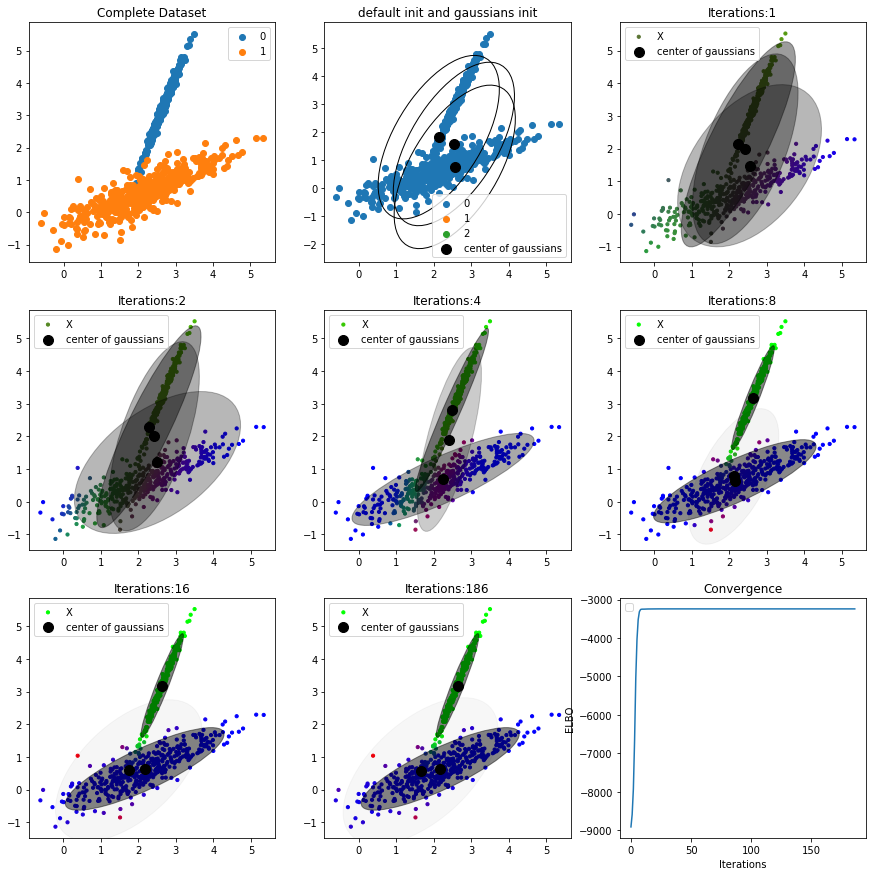

Total time: 4.738459348678589


In [33]:
k_real = 2
vgmm = VariationalGaussianMixtureModel(k_real, size=400)
fig, ax = plt.subplots( figsize=(10,5))
ax.set_title('Original dataset')
plot_labels(vgmm.X, vgmm.labels_real, k = k_real, ax=ax)
plt.show()




k=3
fig, ax = plt.subplots(3,3, figsize=(15,15))
axes = ax.flatten()
vgmm.plot_dataset(n_std=2, ax = axes[0])
vgmm.fit(k=k, n_std=2, mode='default', ax=axes[1])
vgmm.EM(max_iters=1001, mile=[1,2,4,8,16,1000], n_std=2,  tol=1e-10, n_batches=1, ax_list=axes[2:-1], probs=True)
vgmm.plot_ELBO(axes[-1])
plt.show()
print('Total time:',vgmm.time)

C:\Users\alcom\anaconda3\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: covariance is not positive-semidefinite.
  # Remove the CWD from sys.path while we load stuff.


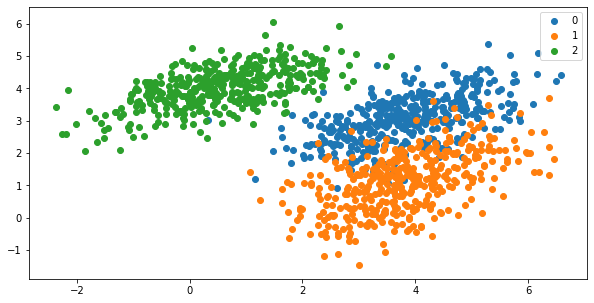

ELBO convergence reached
Total time default: 23.27416968345642
k-means convergence reached
ELBO convergence reached
Total time k-means: 21.901605367660522


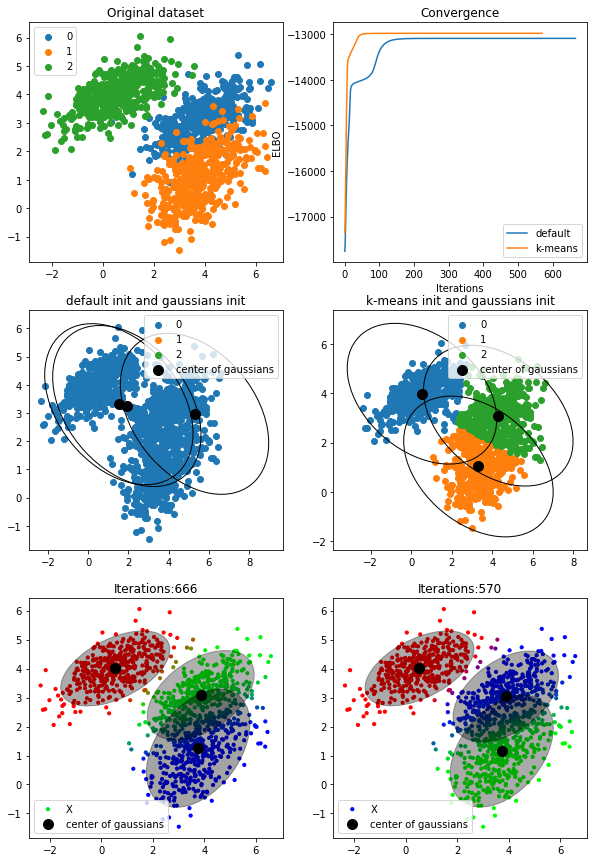

In [64]:
k_real = 3
vgmm = VariationalGaussianMixtureModel(k_real, size=400)
fig, ax = plt.subplots( figsize=(10,5))
ax.set_title('Original dataset')
plot_labels(vgmm.X, vgmm.labels_real, k = k_real, ax=ax)
plt.show()




k = 3
fig, ax = plt.subplots(3,2, figsize=(10,15))
axes = ax.flatten()

plot_labels(vgmm.X, vgmm.labels_real, k = k_real, ax=axes[0], title='Original dataset')

# vgmm.plot_dataset(n_std=2, ax = axes[0])
vgmm.fit(k=k, n_std=2, mode='default', ax=axes[2])
vgmm.EM(max_iters=1001, mile=[10000], n_std=2,  tol=1e-10, n_batches=1, ax_list=axes[4:5], probs=True)
vgmm.plot_ELBO(axes[1])
print('Total time default:',vgmm.time)


# vgmm.plot_dataset(n_std=2, ax = axes[0])
vgmm.fit(k=k, n_std=2, mode='k-means', ax=axes[3])
vgmm.EM(max_iters=1001, mile=[10000], n_std=2,  tol=1e-10, n_batches=1, ax_list=axes[5:6], probs=True)
vgmm.plot_ELBO(axes[1])

print('Total time k-means:', vgmm.time)
plt.show()



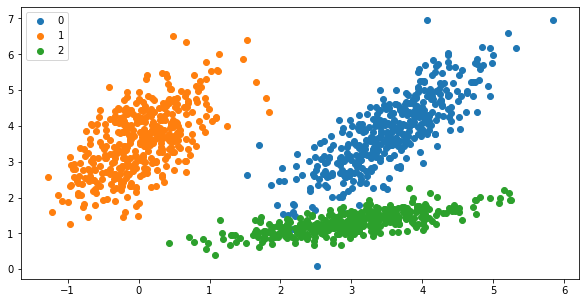

k-means convergence reached
ELBO didn't converge, max_iters reached
Total time 1: 4.2625696659088135
k-means convergence reached
ELBO didn't converge, max_iters reached
Total time 2: 4.178884506225586


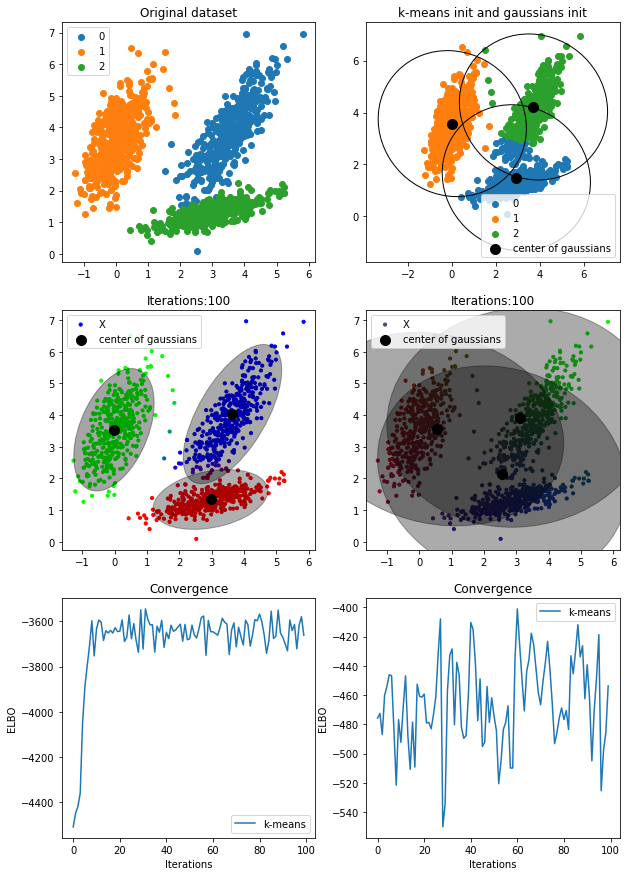

In [38]:
k_real = 3
# vgmm = VariationalGaussianMixtureModel(k_real, size=400)
fig, ax = plt.subplots( figsize=(10,5))
ax.set_title('Original dataset')
plot_labels(vgmm.X, vgmm.labels_real, k = k_real, ax=ax)
plt.show()




k = 3
fig, ax = plt.subplots(3,2, figsize=(10,15))
axes = ax.flatten()

plot_labels(vgmm.X, vgmm.labels_real, k = k_real, ax=axes[0], title='Original dataset')

# vgmm.plot_dataset(n_std=2, ax = axes[0])
vgmm.fit(k=k, n_std=2, mode='k-means', ax=axes[1])
vgmm.EM(max_iters=100, mile=[10000], n_std=2,  tol=1e-10, n_batches=4, ax_list=axes[2:3], probs=True)
vgmm.plot_ELBO(axes[4])
print('Total time 1:',vgmm.time)


# vgmm.plot_dataset(n_std=2, ax = axes[0])
vgmm.fit(k=k, n_std=2, mode='k-means', ax=None)
vgmm.EM(max_iters=100, mile=[10000], n_std=2,  tol=1e-10, n_batches=100, ax_list=axes[3:4], probs=True)
vgmm.plot_ELBO(axes[5])

print('Total time 2:', vgmm.time)
plt.show()


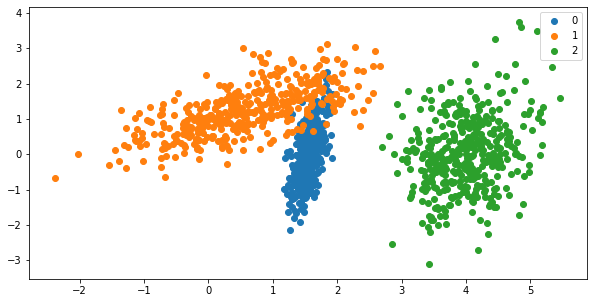

k-means convergence reached
ELBO didn't converge, max_iters reached


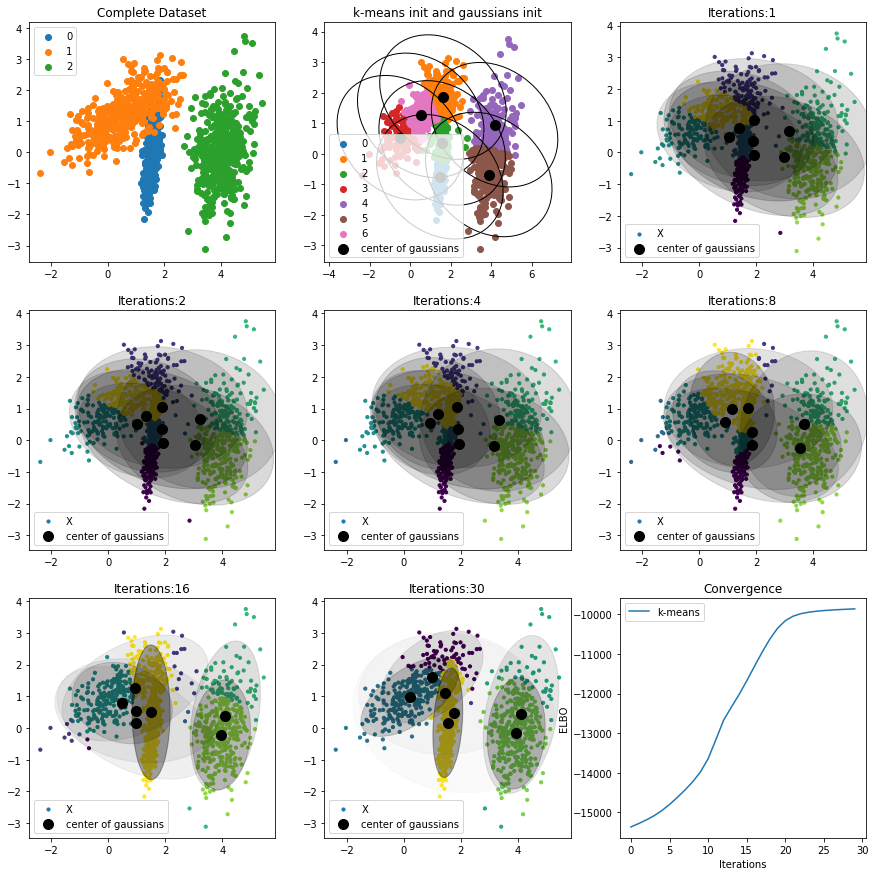

Total time: 3.848806142807007


In [33]:
k_real = 3
# vgmm = VariationalGaussianMixtureModel(k_real, size=400)
fig, ax = plt.subplots( figsize=(10,5))
ax.set_title('Original dataset')
plot_labels(vgmm.X, vgmm.labels_real, k = k_real, ax=ax)
plt.show()




k=3
fig, ax = plt.subplots(3,3, figsize=(15,15))
axes = ax.flatten()
vgmm.plot_dataset(n_std=2, ax = axes[0])
vgmm.fit(k=k, n_std=2, mode='k-means', ax=axes[1])
vgmm.EM(max_iters=30, mile=[1,2,4,8,16,1000], n_std=2,  tol=1e-10, n_batches=1, ax_list=axes[2:-1], probs=False)
vgmm.plot_ELBO(axes[-1])
plt.show()
print('Total time:',vgmm.time)

https://matplotlib.org/3.1.1/gallery/statistics/confidence_ellipse.html#sphx-glr-gallery-statistics-confidence-ellipse-py